In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
from scipy.special import expit
from scipy.stats import logistic
import statsmodels.formula.api as smf

from sklearn import tree
import graphviz
from graphviz import Source
 
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.tree import export_graphviz
import sklearn.metrics as met
from sklearn.metrics import confusion_matrix


from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

%matplotlib inline

pd.set_option('display.max_columns', None)

In [4]:
#using the reduced dataset since way too many columns that I am not going to analyze are in
#the original (merged) datasets

suspensionData = pd.read_csv("201516suspensionsRED.csv", skipfooter = 1)
suspensionData

/Users/zeigna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


,DBN,LOCATION NAME,LOCATION CATEGORY,ADMINISTRATIVE DISTRICT,TOTAL STUDENTS,BLACK STUDENTS,HISPANIC STUDENTS,WHITE STUDENTS,GEN ED STUDENTS,SWD STUDENTS,FEMALE STUDENTS,MALE STUDENTS,NON-ELL STUDENTS,ELL STUDENTS,NON-STH STUDENTS,STH STUDENTS,BLACK SUSPENSIONS NYPD Contact,HISPANIC SUSPENSIONS NYPD Contact,WHITE SUSPENSIONS NYPD Contact,TOTAL SUSPENSIONS NYPD Contact,GEN ED SUSPENSIONS NYPD Contact,SWD SUSPENSIONS NYPD Contact,MALE SUSPENSIONS NYPD Contact,FEMALE SUSPENSIONS NYPD Contact,NON-ELL SUSPENSIONS NYPD Contact,ELL SUSPENSIONS NYPD Contact,NON-STH SUSPENSIONS NYPD Contact,STH SUSPENSIONS NYPD Contact,Black REMOVALS,Black PRINCIPAL,Black SUPERINTENDENT,Black EXPULSIONS,Hispanic REMOVALS,Hispanic PRINCIPAL,Hispanic SUPERINTENDENT,Hispanic EXPULSIONS,White REMOVALS,White PRINCIPAL,White SUPERINTENDENT,White EXPULSIONS
0,01M015,P.S. 015 Roberto Clemente,Elementary,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
1,01M019,P.S. 019 Asher Levy,Elementary,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
2,01M020,P.S. 020 Anna Silver,Elementary,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,8,*,*,*,*,*,*,*
3,01M034,P.S. 034 Franklin D. Roosevelt,K-8,1,14,*,*,*,8,6,8,6,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,12,10,9,*,14,13,*,*,*,*,*,*
4,01M063,The STAR Academy - P.S.63,Elementary,1,6,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,21,*,*,*,22,*,*,*,*,*,*,*
5,01M064,P.S. 064 Robert Simon,Elementary,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
6,01M110,P.S. 110 Florence Nightingale,Elementary,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
7,01M134,P.S. 134 Henrietta Szold,Elementary,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
8,01M137,P.S. 137 John L. Bernstein,Elementary,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
9,01M140,P.S. 140 Nathan Straus,K-8,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,6,8,*,*,*,*,*,*


In [5]:
#load the daily attendance data for each school

attend = pd.read_csv("2015-2016_historical_daily_attendance_by_school.csv")
attend.head()

,School,Date,SchoolYear,Enrolled,Present,Absent,Released
0,01M015,20150909,20152016,177,159,18,0
1,01M015,20150910,20152016,173,159,14,0
2,01M015,20150911,20152016,174,164,10,0
3,01M015,20150916,20152016,172,159,13,0
4,01M015,20150917,20152016,172,165,7,0


The variable "DBN" in the SuspensionData dataset seems to correspond to the variable "School" in the Attend dataset

I will change the name of the variable in attend to match suspensionData


In [6]:
# rename the "school" column in attend.  The equivalent in SuspensionsData is DBN and I want
#join the two data sets so I need a column in common between the two

attend.columns = ["DBN", "Date", "SchoolYear", "Enrolled", "Present", "Absent", "Released"]

In [7]:
#for some reason I need to view the (head of) dataset from a different cell
attend.head()

,DBN,Date,SchoolYear,Enrolled,Present,Absent,Released
0,01M015,20150909,20152016,177,159,18,0
1,01M015,20150910,20152016,173,159,14,0
2,01M015,20150911,20152016,174,164,10,0
3,01M015,20150916,20152016,172,159,13,0
4,01M015,20150917,20152016,172,165,7,0


In [8]:
attend_group = attend.groupby('DBN', as_index=False).mean()
#df = attend.groupby("DBN").mean()
attend_group = attend_group.drop("Date", axis = 1)
attend_group = attend_group.drop("SchoolYear", axis = 1)
attend_group.head()


,DBN,Enrolled,Present,Absent,Released
0,01M015,167.797753,156.005618,11.634831,0.157303
1,01M019,270.466292,246.297753,23.926966,0.241573
2,01M020,574.067416,539.679775,33.898876,0.488764
3,01M034,393.977528,360.679775,33.112360,0.185393
4,01M063,200.382022,187.061798,13.073034,0.247191


In [9]:
attend_group.shape

(1634, 5)

In [10]:
#get the mean attendance by school

attendMean = attend.groupby("DBN").mean()["Enrolled"]
attendMean.head()

DBN
01M015    167.797753
01M019    270.466292
01M020    574.067416
01M034    393.977528
01M063    200.382022
Name: Enrolled, dtype: float64

In [11]:
#get the mean absences by school

attendAbs = attend.groupby("DBN").mean()["Absent"]
attendAbs.head()

DBN
01M015    11.634831
01M019    23.926966
01M020    33.898876
01M034    33.112360
01M063    13.073034
Name: Absent, dtype: float64

In [12]:
suspensionData = suspensionData.drop("LOCATION NAME", axis = 1)
suspensionData = suspensionData.drop("LOCATION CATEGORY", axis = 1)
suspensionData.head()

,DBN,ADMINISTRATIVE DISTRICT,TOTAL STUDENTS,BLACK STUDENTS,HISPANIC STUDENTS,WHITE STUDENTS,GEN ED STUDENTS,SWD STUDENTS,FEMALE STUDENTS,MALE STUDENTS,NON-ELL STUDENTS,ELL STUDENTS,NON-STH STUDENTS,STH STUDENTS,BLACK SUSPENSIONS NYPD Contact,HISPANIC SUSPENSIONS NYPD Contact,WHITE SUSPENSIONS NYPD Contact,TOTAL SUSPENSIONS NYPD Contact,GEN ED SUSPENSIONS NYPD Contact,SWD SUSPENSIONS NYPD Contact,MALE SUSPENSIONS NYPD Contact,FEMALE SUSPENSIONS NYPD Contact,NON-ELL SUSPENSIONS NYPD Contact,ELL SUSPENSIONS NYPD Contact,NON-STH SUSPENSIONS NYPD Contact,STH SUSPENSIONS NYPD Contact,Black REMOVALS,Black PRINCIPAL,Black SUPERINTENDENT,Black EXPULSIONS,Hispanic REMOVALS,Hispanic PRINCIPAL,Hispanic SUPERINTENDENT,Hispanic EXPULSIONS,White REMOVALS,White PRINCIPAL,White SUPERINTENDENT,White EXPULSIONS
0,01M015,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
1,01M019,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
2,01M020,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,8,*,*,*,*,*,*,*
3,01M034,1,14,*,*,*,8,6,8,6,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,12,10,9,*,14,13,*,*,*,*,*,*
4,01M063,1,6,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,21,*,*,*,22,*,*,*,*,*,*,*


In [13]:
suspensionData.shape

(1742, 38)

In [14]:
attend_group.head()

,DBN,Enrolled,Present,Absent,Released
0,01M015,167.797753,156.005618,11.634831,0.157303
1,01M019,270.466292,246.297753,23.926966,0.241573
2,01M020,574.067416,539.679775,33.898876,0.488764
3,01M034,393.977528,360.679775,33.112360,0.185393
4,01M063,200.382022,187.061798,13.073034,0.247191


In [15]:
suspensionData.head()

,DBN,ADMINISTRATIVE DISTRICT,TOTAL STUDENTS,BLACK STUDENTS,HISPANIC STUDENTS,WHITE STUDENTS,GEN ED STUDENTS,SWD STUDENTS,FEMALE STUDENTS,MALE STUDENTS,NON-ELL STUDENTS,ELL STUDENTS,NON-STH STUDENTS,STH STUDENTS,BLACK SUSPENSIONS NYPD Contact,HISPANIC SUSPENSIONS NYPD Contact,WHITE SUSPENSIONS NYPD Contact,TOTAL SUSPENSIONS NYPD Contact,GEN ED SUSPENSIONS NYPD Contact,SWD SUSPENSIONS NYPD Contact,MALE SUSPENSIONS NYPD Contact,FEMALE SUSPENSIONS NYPD Contact,NON-ELL SUSPENSIONS NYPD Contact,ELL SUSPENSIONS NYPD Contact,NON-STH SUSPENSIONS NYPD Contact,STH SUSPENSIONS NYPD Contact,Black REMOVALS,Black PRINCIPAL,Black SUPERINTENDENT,Black EXPULSIONS,Hispanic REMOVALS,Hispanic PRINCIPAL,Hispanic SUPERINTENDENT,Hispanic EXPULSIONS,White REMOVALS,White PRINCIPAL,White SUPERINTENDENT,White EXPULSIONS
0,01M015,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
1,01M019,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
2,01M020,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,8,*,*,*,*,*,*,*
3,01M034,1,14,*,*,*,8,6,8,6,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,12,10,9,*,14,13,*,*,*,*,*,*
4,01M063,1,6,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,21,*,*,*,22,*,*,*,*,*,*,*


In [16]:
combo = attend_group.merge(suspensionData, how = "inner")
combo


,DBN,Enrolled,Present,Absent,Released,ADMINISTRATIVE DISTRICT,TOTAL STUDENTS,BLACK STUDENTS,HISPANIC STUDENTS,WHITE STUDENTS,GEN ED STUDENTS,SWD STUDENTS,FEMALE STUDENTS,MALE STUDENTS,NON-ELL STUDENTS,ELL STUDENTS,NON-STH STUDENTS,STH STUDENTS,BLACK SUSPENSIONS NYPD Contact,HISPANIC SUSPENSIONS NYPD Contact,WHITE SUSPENSIONS NYPD Contact,TOTAL SUSPENSIONS NYPD Contact,GEN ED SUSPENSIONS NYPD Contact,SWD SUSPENSIONS NYPD Contact,MALE SUSPENSIONS NYPD Contact,FEMALE SUSPENSIONS NYPD Contact,NON-ELL SUSPENSIONS NYPD Contact,ELL SUSPENSIONS NYPD Contact,NON-STH SUSPENSIONS NYPD Contact,STH SUSPENSIONS NYPD Contact,Black REMOVALS,Black PRINCIPAL,Black SUPERINTENDENT,Black EXPULSIONS,Hispanic REMOVALS,Hispanic PRINCIPAL,Hispanic SUPERINTENDENT,Hispanic EXPULSIONS,White REMOVALS,White PRINCIPAL,White SUPERINTENDENT,White EXPULSIONS
0,01M015,167.797753,156.005618,11.634831,0.157303,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
1,01M019,270.466292,246.297753,23.926966,0.241573,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
2,01M020,574.067416,539.679775,33.898876,0.488764,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,8,*,*,*,*,*,*,*
3,01M034,393.977528,360.679775,33.112360,0.185393,1,14,*,*,*,8,6,8,6,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,12,10,9,*,14,13,*,*,*,*,*,*
4,01M063,200.382022,187.061798,13.073034,0.247191,1,6,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,21,*,*,*,22,*,*,*,*,*,*,*
5,01M064,262.084270,238.848315,22.859551,0.376404,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
6,01M110,387.426966,369.196629,17.831461,0.398876,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
7,01M134,263.814607,241.657303,21.960674,0.196629,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
8,01M140,378.129213,349.814607,28.224719,0.089888,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,6,8,*,*,*,*,*,*
9,01M142,357.533708,330.544944,26.988764,0.000000,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*


In [17]:
combo = combo.fillna(0)
combo

,DBN,Enrolled,Present,Absent,Released,ADMINISTRATIVE DISTRICT,TOTAL STUDENTS,BLACK STUDENTS,HISPANIC STUDENTS,WHITE STUDENTS,GEN ED STUDENTS,SWD STUDENTS,FEMALE STUDENTS,MALE STUDENTS,NON-ELL STUDENTS,ELL STUDENTS,NON-STH STUDENTS,STH STUDENTS,BLACK SUSPENSIONS NYPD Contact,HISPANIC SUSPENSIONS NYPD Contact,WHITE SUSPENSIONS NYPD Contact,TOTAL SUSPENSIONS NYPD Contact,GEN ED SUSPENSIONS NYPD Contact,SWD SUSPENSIONS NYPD Contact,MALE SUSPENSIONS NYPD Contact,FEMALE SUSPENSIONS NYPD Contact,NON-ELL SUSPENSIONS NYPD Contact,ELL SUSPENSIONS NYPD Contact,NON-STH SUSPENSIONS NYPD Contact,STH SUSPENSIONS NYPD Contact,Black REMOVALS,Black PRINCIPAL,Black SUPERINTENDENT,Black EXPULSIONS,Hispanic REMOVALS,Hispanic PRINCIPAL,Hispanic SUPERINTENDENT,Hispanic EXPULSIONS,White REMOVALS,White PRINCIPAL,White SUPERINTENDENT,White EXPULSIONS
0,01M015,167.797753,156.005618,11.634831,0.157303,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
1,01M019,270.466292,246.297753,23.926966,0.241573,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
2,01M020,574.067416,539.679775,33.898876,0.488764,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,8,*,*,*,*,*,*,*
3,01M034,393.977528,360.679775,33.112360,0.185393,1,14,*,*,*,8,6,8,6,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,12,10,9,*,14,13,*,*,*,*,*,*
4,01M063,200.382022,187.061798,13.073034,0.247191,1,6,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,21,*,*,*,22,*,*,*,*,*,*,*
5,01M064,262.084270,238.848315,22.859551,0.376404,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
6,01M110,387.426966,369.196629,17.831461,0.398876,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
7,01M134,263.814607,241.657303,21.960674,0.196629,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
8,01M140,378.129213,349.814607,28.224719,0.089888,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,6,8,*,*,*,*,*,*
9,01M142,357.533708,330.544944,26.988764,0.000000,1,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*


In [18]:
combo.to_csv('combo.csv')

In [19]:
comboData = pd.read_csv('combo.csv', na_values = ["*"])
comboData


,Unnamed: 0,DBN,Enrolled,Present,Absent,Released,ADMINISTRATIVE DISTRICT,TOTAL STUDENTS,BLACK STUDENTS,HISPANIC STUDENTS,WHITE STUDENTS,GEN ED STUDENTS,SWD STUDENTS,FEMALE STUDENTS,MALE STUDENTS,NON-ELL STUDENTS,ELL STUDENTS,NON-STH STUDENTS,STH STUDENTS,BLACK SUSPENSIONS NYPD Contact,HISPANIC SUSPENSIONS NYPD Contact,WHITE SUSPENSIONS NYPD Contact,TOTAL SUSPENSIONS NYPD Contact,GEN ED SUSPENSIONS NYPD Contact,SWD SUSPENSIONS NYPD Contact,MALE SUSPENSIONS NYPD Contact,FEMALE SUSPENSIONS NYPD Contact,NON-ELL SUSPENSIONS NYPD Contact,ELL SUSPENSIONS NYPD Contact,NON-STH SUSPENSIONS NYPD Contact,STH SUSPENSIONS NYPD Contact,Black REMOVALS,Black PRINCIPAL,Black SUPERINTENDENT,Black EXPULSIONS,Hispanic REMOVALS,Hispanic PRINCIPAL,Hispanic SUPERINTENDENT,Hispanic EXPULSIONS,White REMOVALS,White PRINCIPAL,White SUPERINTENDENT,White EXPULSIONS
0,0,01M015,167.797753,156.005618,11.634831,0.157303,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,01M019,270.466292,246.297753,23.926966,0.241573,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,01M020,574.067416,539.679775,33.898876,0.488764,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,01M034,393.977528,360.679775,33.112360,0.185393,1,14.0,NaN,NaN,NaN,8.0,6.0,8.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,10.0,9.0,NaN,14.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,01M063,200.382022,187.061798,13.073034,0.247191,1,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,01M064,262.084270,238.848315,22.859551,0.376404,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,01M110,387.426966,369.196629,17.831461,0.398876,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,01M134,263.814607,241.657303,21.960674,0.196629,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,01M140,378.129213,349.814607,28.224719,0.089888,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
9,9,01M142,357.533708,330.544944,26.988764,0.000000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
comboDataOrig = comboData
comboDataOrig

,Unnamed: 0,DBN,Enrolled,Present,Absent,Released,ADMINISTRATIVE DISTRICT,TOTAL STUDENTS,BLACK STUDENTS,HISPANIC STUDENTS,WHITE STUDENTS,GEN ED STUDENTS,SWD STUDENTS,FEMALE STUDENTS,MALE STUDENTS,NON-ELL STUDENTS,ELL STUDENTS,NON-STH STUDENTS,STH STUDENTS,BLACK SUSPENSIONS NYPD Contact,HISPANIC SUSPENSIONS NYPD Contact,WHITE SUSPENSIONS NYPD Contact,TOTAL SUSPENSIONS NYPD Contact,GEN ED SUSPENSIONS NYPD Contact,SWD SUSPENSIONS NYPD Contact,MALE SUSPENSIONS NYPD Contact,FEMALE SUSPENSIONS NYPD Contact,NON-ELL SUSPENSIONS NYPD Contact,ELL SUSPENSIONS NYPD Contact,NON-STH SUSPENSIONS NYPD Contact,STH SUSPENSIONS NYPD Contact,Black REMOVALS,Black PRINCIPAL,Black SUPERINTENDENT,Black EXPULSIONS,Hispanic REMOVALS,Hispanic PRINCIPAL,Hispanic SUPERINTENDENT,Hispanic EXPULSIONS,White REMOVALS,White PRINCIPAL,White SUPERINTENDENT,White EXPULSIONS
0,0,01M015,167.797753,156.005618,11.634831,0.157303,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,01M019,270.466292,246.297753,23.926966,0.241573,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,01M020,574.067416,539.679775,33.898876,0.488764,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,01M034,393.977528,360.679775,33.112360,0.185393,1,14.0,NaN,NaN,NaN,8.0,6.0,8.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,10.0,9.0,NaN,14.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,01M063,200.382022,187.061798,13.073034,0.247191,1,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,01M064,262.084270,238.848315,22.859551,0.376404,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,01M110,387.426966,369.196629,17.831461,0.398876,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,01M134,263.814607,241.657303,21.960674,0.196629,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,01M140,378.129213,349.814607,28.224719,0.089888,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
9,9,01M142,357.533708,330.544944,26.988764,0.000000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
comboData.dtypes

Unnamed: 0                             int64
DBN                                   object
Enrolled                             float64
Present                              float64
Absent                               float64
Released                             float64
ADMINISTRATIVE DISTRICT                int64
TOTAL STUDENTS                       float64
BLACK STUDENTS                       float64
HISPANIC STUDENTS                    float64
WHITE STUDENTS                       float64
GEN ED STUDENTS                      float64
SWD STUDENTS                         float64
FEMALE STUDENTS                      float64
MALE STUDENTS                        float64
NON-ELL STUDENTS                     float64
ELL STUDENTS                         float64
NON-STH STUDENTS                     float64
STH STUDENTS                         float64
BLACK SUSPENSIONS NYPD Contact       float64
HISPANIC SUSPENSIONS NYPD Contact    float64
WHITE SUSPENSIONS NYPD Contact       float64
TOTAL SUSP

In [22]:
def boro (x):
    if x.count("X") > 0:
        return "Bronx"
    elif x.count("M") >0:
        return "Manhattan"
    elif x.count("R") >0:
        return "Staten Island"
    elif x.count("K") >0:
        return "Brooklyn"
    elif x.count("Q") >0:
        return "Queens"
    else:
        return "Other"
    

    

In [23]:
comboData["Borough"] = comboData["DBN"].apply(boro)
comboData

,Unnamed: 0,DBN,Enrolled,Present,Absent,Released,ADMINISTRATIVE DISTRICT,TOTAL STUDENTS,BLACK STUDENTS,HISPANIC STUDENTS,WHITE STUDENTS,GEN ED STUDENTS,SWD STUDENTS,FEMALE STUDENTS,MALE STUDENTS,NON-ELL STUDENTS,ELL STUDENTS,NON-STH STUDENTS,STH STUDENTS,BLACK SUSPENSIONS NYPD Contact,HISPANIC SUSPENSIONS NYPD Contact,WHITE SUSPENSIONS NYPD Contact,TOTAL SUSPENSIONS NYPD Contact,GEN ED SUSPENSIONS NYPD Contact,SWD SUSPENSIONS NYPD Contact,MALE SUSPENSIONS NYPD Contact,FEMALE SUSPENSIONS NYPD Contact,NON-ELL SUSPENSIONS NYPD Contact,ELL SUSPENSIONS NYPD Contact,NON-STH SUSPENSIONS NYPD Contact,STH SUSPENSIONS NYPD Contact,Black REMOVALS,Black PRINCIPAL,Black SUPERINTENDENT,Black EXPULSIONS,Hispanic REMOVALS,Hispanic PRINCIPAL,Hispanic SUPERINTENDENT,Hispanic EXPULSIONS,White REMOVALS,White PRINCIPAL,White SUPERINTENDENT,White EXPULSIONS,Borough
0,0,01M015,167.797753,156.005618,11.634831,0.157303,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manhattan
1,1,01M019,270.466292,246.297753,23.926966,0.241573,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manhattan
2,2,01M020,574.067416,539.679775,33.898876,0.488764,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manhattan
3,3,01M034,393.977528,360.679775,33.112360,0.185393,1,14.0,NaN,NaN,NaN,8.0,6.0,8.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,10.0,9.0,NaN,14.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,Manhattan
4,4,01M063,200.382022,187.061798,13.073034,0.247191,1,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manhattan
5,5,01M064,262.084270,238.848315,22.859551,0.376404,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manhattan
6,6,01M110,387.426966,369.196629,17.831461,0.398876,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manhattan
7,7,01M134,263.814607,241.657303,21.960674,0.196629,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manhattan
8,8,01M140,378.129213,349.814607,28.224719,0.089888,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,Manhattan
9,9,01M142,357.533708,330.544944,26.988764,0.000000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manhattan


In [24]:
def boroNum(x):
    if x == "Bronx":
        return 1
    elif x == "Manhattan":
        return 2
    elif x == "Staten Island":
        return 3
    elif x == "Brooklyn":
        return 4
    elif x == "Queens":
        return 5
    else: 
        return 0

In [25]:
comboData["BoroughNum"] = comboData["Borough"].apply(boroNum)
comboData.head()

,Unnamed: 0,DBN,Enrolled,Present,Absent,Released,ADMINISTRATIVE DISTRICT,TOTAL STUDENTS,BLACK STUDENTS,HISPANIC STUDENTS,WHITE STUDENTS,GEN ED STUDENTS,SWD STUDENTS,FEMALE STUDENTS,MALE STUDENTS,NON-ELL STUDENTS,ELL STUDENTS,NON-STH STUDENTS,STH STUDENTS,BLACK SUSPENSIONS NYPD Contact,HISPANIC SUSPENSIONS NYPD Contact,WHITE SUSPENSIONS NYPD Contact,TOTAL SUSPENSIONS NYPD Contact,GEN ED SUSPENSIONS NYPD Contact,SWD SUSPENSIONS NYPD Contact,MALE SUSPENSIONS NYPD Contact,FEMALE SUSPENSIONS NYPD Contact,NON-ELL SUSPENSIONS NYPD Contact,ELL SUSPENSIONS NYPD Contact,NON-STH SUSPENSIONS NYPD Contact,STH SUSPENSIONS NYPD Contact,Black REMOVALS,Black PRINCIPAL,Black SUPERINTENDENT,Black EXPULSIONS,Hispanic REMOVALS,Hispanic PRINCIPAL,Hispanic SUPERINTENDENT,Hispanic EXPULSIONS,White REMOVALS,White PRINCIPAL,White SUPERINTENDENT,White EXPULSIONS,Borough,BoroughNum
0,0,01M015,167.797753,156.005618,11.634831,0.157303,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manhattan,2
1,1,01M019,270.466292,246.297753,23.926966,0.241573,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manhattan,2
2,2,01M020,574.067416,539.679775,33.898876,0.488764,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manhattan,2
3,3,01M034,393.977528,360.679775,33.112360,0.185393,1,14.0,NaN,NaN,NaN,8.0,6.0,8.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,10.0,9.0,NaN,14.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,Manhattan,2
4,4,01M063,200.382022,187.061798,13.073034,0.247191,1,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manhattan,2


In [26]:
comboData = comboData.fillna(0)
comboData.head()

,Unnamed: 0,DBN,Enrolled,Present,Absent,Released,ADMINISTRATIVE DISTRICT,TOTAL STUDENTS,BLACK STUDENTS,HISPANIC STUDENTS,WHITE STUDENTS,GEN ED STUDENTS,SWD STUDENTS,FEMALE STUDENTS,MALE STUDENTS,NON-ELL STUDENTS,ELL STUDENTS,NON-STH STUDENTS,STH STUDENTS,BLACK SUSPENSIONS NYPD Contact,HISPANIC SUSPENSIONS NYPD Contact,WHITE SUSPENSIONS NYPD Contact,TOTAL SUSPENSIONS NYPD Contact,GEN ED SUSPENSIONS NYPD Contact,SWD SUSPENSIONS NYPD Contact,MALE SUSPENSIONS NYPD Contact,FEMALE SUSPENSIONS NYPD Contact,NON-ELL SUSPENSIONS NYPD Contact,ELL SUSPENSIONS NYPD Contact,NON-STH SUSPENSIONS NYPD Contact,STH SUSPENSIONS NYPD Contact,Black REMOVALS,Black PRINCIPAL,Black SUPERINTENDENT,Black EXPULSIONS,Hispanic REMOVALS,Hispanic PRINCIPAL,Hispanic SUPERINTENDENT,Hispanic EXPULSIONS,White REMOVALS,White PRINCIPAL,White SUPERINTENDENT,White EXPULSIONS,Borough,BoroughNum
0,0,01M015,167.797753,156.005618,11.634831,0.157303,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Manhattan,2
1,1,01M019,270.466292,246.297753,23.926966,0.241573,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Manhattan,2
2,2,01M020,574.067416,539.679775,33.898876,0.488764,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Manhattan,2
3,3,01M034,393.977528,360.679775,33.112360,0.185393,1,14.0,0.0,0.0,0.0,8.0,6.0,8.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,10.0,9.0,0.0,14.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,Manhattan,2
4,4,01M063,200.382022,187.061798,13.073034,0.247191,1,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Manhattan,2


In [27]:
comboDataViz = comboData.drop(["Unnamed: 0", "DBN", "Enrolled", "Present", "Absent", "Released"], axis = 1)
comboDataViz.head()

Viz = comboData

In [28]:
#since we have a mean value per school in the attend dataset, I want to add this as a column to the 
#suspensiondata dataset

#but I need to match/merge on the DBN variable

#since there is a difference in the number of rows for the suspensiondata vs the attend data,
# I will merge only on the rows in common



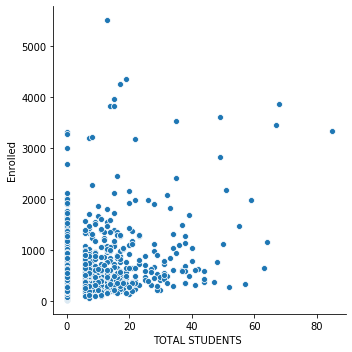

In [29]:
sns.relplot(x = "TOTAL STUDENTS ", y = "Enrolled", data = comboData)

#sns.plt.ylim(0, 2000)
#sns.plt.xlim(0, 20)

#this is the mean enrollment per school compared to the total number of students per school
#can I do a mean vs a sum???

#maybe convert both to z-scores so comparable??

In [30]:
comboData["meanStudents"] = (comboData["TOTAL STUDENTS "]/comboData["TOTAL STUDENTS "].sum())*100
comboData["meanStudents"]

0       0.000000
1       0.000000
2       0.000000
3       0.184623
4       0.079124
          ...   
1623    0.000000
1624    0.000000
1625    0.000000
1626    0.000000
1627    0.000000
Name: meanStudents, Length: 1628, dtype: float64

In [31]:
lm = smf.ols("Q('TOTAL STUDENTS ') ~ Enrolled", data = comboData).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Q('TOTAL STUDENTS ')   R-squared:                       0.083
Model:                              OLS   Adj. R-squared:                  0.082
Method:                   Least Squares   F-statistic:                     146.4
Date:                  Wed, 11 Dec 2019   Prob (F-statistic):           2.51e-32
Time:                          17:30:24   Log-Likelihood:                -5908.6
No. Observations:                  1628   AIC:                         1.182e+04
Df Residuals:                      1626   BIC:                         1.183e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3239      0.356      3.714      0.000       0.625       2.023
Enrolled       0.0056      0.000     12.099      0.000       0.005       0.006
==============================================================================
Omnibus:                      929.661   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7425.645
Skew:                           2.619   Prob(JB):                         0.00
Kurtosis:                      12.058   Cond. No.                     1.22e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
lm = smf.ols("Q('TOTAL STUDENTS ') ~ Enrolled + Absent + Q('BLACK STUDENTS') + Q('HISPANIC STUDENTS') + Q('WHITE STUDENTS')", data = comboData).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Q('TOTAL STUDENTS ')   R-squared:                       0.760
Model:                              OLS   Adj. R-squared:                  0.759
Method:                   Least Squares   F-statistic:                     1026.
Date:                  Wed, 11 Dec 2019   Prob (F-statistic):               0.00
Time:                          17:30:27   Log-Likelihood:                -4818.0
No. Observations:                  1628   AIC:                             9648.
Df Residuals:                      1622   BIC:                             9680.
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.7833      0.188      4.161      0.000       0.414       1.153
Enrolled                   0.0004      0.000      1.078      0.281      -0.000       0.001
Absent                     0.0176      0.004      4.759      0.000       0.010       0.025
Q('BLACK STUDENTS')        1.0305      0.024     42.402      0.000       0.983       1.078
Q('HISPANIC STUDENTS')     1.0721      0.032     33.236      0.000       1.009       1.135
Q('WHITE STUDENTS')        0.8699      0.125      6.932      0.000       0.624       1.116
==============================================================================
Omnibus:                     1723.874   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           119290.447
Skew:                           5.176   Prob(JB):                         0.00
Kurtosis:                      43.638   Cond. No.                     1.28e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
lm = smf.ols("Q('TOTAL STUDENTS ') ~ Absent + Q('MALE STUDENTS') + Q('FEMALE STUDENTS')+ Q('BLACK STUDENTS') + Q('HISPANIC STUDENTS') + Q('WHITE STUDENTS')", data = comboData).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Q('TOTAL STUDENTS ')   R-squared:                       0.818
Model:                              OLS   Adj. R-squared:                  0.817
Method:                   Least Squares   F-statistic:                     1210.
Date:                  Wed, 11 Dec 2019   Prob (F-statistic):               0.00
Time:                          17:30:28   Log-Likelihood:                -4594.0
No. Observations:                  1628   AIC:                             9202.
Df Residuals:                      1621   BIC:                             9240.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.0688      0.150      7.116      0.000       0.774       1.363
Absent                     0.0175      0.002      7.437      0.000       0.013       0.022
Q('MALE STUDENTS')         0.4451      0.038     11.614      0.000       0.370       0.520
Q('FEMALE STUDENTS')       0.3712      0.068      5.483      0.000       0.238       0.504
Q('BLACK STUDENTS')        0.6666      0.027     24.526      0.000       0.613       0.720
Q('HISPANIC STUDENTS')     0.7427      0.032     23.255      0.000       0.680       0.805
Q('WHITE STUDENTS')        0.6385      0.110      5.823      0.000       0.423       0.854
==============================================================================
Omnibus:                      906.095   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8547.650
Skew:                           2.456   Prob(JB):                         0.00
Kurtosis:                      13.093   Cond. No.                         102.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
comboData.dtypes

Unnamed: 0                             int64
DBN                                   object
Enrolled                             float64
Present                              float64
Absent                               float64
Released                             float64
ADMINISTRATIVE DISTRICT                int64
TOTAL STUDENTS                       float64
BLACK STUDENTS                       float64
HISPANIC STUDENTS                    float64
WHITE STUDENTS                       float64
GEN ED STUDENTS                      float64
SWD STUDENTS                         float64
FEMALE STUDENTS                      float64
MALE STUDENTS                        float64
NON-ELL STUDENTS                     float64
ELL STUDENTS                         float64
NON-STH STUDENTS                     float64
STH STUDENTS                         float64
BLACK SUSPENSIONS NYPD Contact       float64
HISPANIC SUSPENSIONS NYPD Contact    float64
WHITE SUSPENSIONS NYPD Contact       float64
TOTAL SUSP

In [35]:
comboData.shape

(1628, 46)

In [36]:
comboData.head()

,Unnamed: 0,DBN,Enrolled,Present,Absent,Released,ADMINISTRATIVE DISTRICT,TOTAL STUDENTS,BLACK STUDENTS,HISPANIC STUDENTS,WHITE STUDENTS,GEN ED STUDENTS,SWD STUDENTS,FEMALE STUDENTS,MALE STUDENTS,NON-ELL STUDENTS,ELL STUDENTS,NON-STH STUDENTS,STH STUDENTS,BLACK SUSPENSIONS NYPD Contact,HISPANIC SUSPENSIONS NYPD Contact,WHITE SUSPENSIONS NYPD Contact,TOTAL SUSPENSIONS NYPD Contact,GEN ED SUSPENSIONS NYPD Contact,SWD SUSPENSIONS NYPD Contact,MALE SUSPENSIONS NYPD Contact,FEMALE SUSPENSIONS NYPD Contact,NON-ELL SUSPENSIONS NYPD Contact,ELL SUSPENSIONS NYPD Contact,NON-STH SUSPENSIONS NYPD Contact,STH SUSPENSIONS NYPD Contact,Black REMOVALS,Black PRINCIPAL,Black SUPERINTENDENT,Black EXPULSIONS,Hispanic REMOVALS,Hispanic PRINCIPAL,Hispanic SUPERINTENDENT,Hispanic EXPULSIONS,White REMOVALS,White PRINCIPAL,White SUPERINTENDENT,White EXPULSIONS,Borough,BoroughNum,meanStudents
0,0,01M015,167.797753,156.005618,11.634831,0.157303,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Manhattan,2,0.000000
1,1,01M019,270.466292,246.297753,23.926966,0.241573,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Manhattan,2,0.000000
2,2,01M020,574.067416,539.679775,33.898876,0.488764,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Manhattan,2,0.000000
3,3,01M034,393.977528,360.679775,33.112360,0.185393,1,14.0,0.0,0.0,0.0,8.0,6.0,8.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,10.0,9.0,0.0,14.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,Manhattan,2,0.184623
4,4,01M063,200.382022,187.061798,13.073034,0.247191,1,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Manhattan,2,0.079124


In [37]:
z = comboData.iloc[:,[2, 3, 4, 6, 7, 43 ]]
z.head()

## this is not for any calculation
## this is just to ensure I selected the columns I wanted to select

,Enrolled,Present,Absent,ADMINISTRATIVE DISTRICT,TOTAL STUDENTS,Borough
0,167.797753,156.005618,11.634831,1,0.0,Manhattan
1,270.466292,246.297753,23.926966,1,0.0,Manhattan
2,574.067416,539.679775,33.898876,1,0.0,Manhattan
3,393.977528,360.679775,33.112360,1,14.0,Manhattan
4,200.382022,187.061798,13.073034,1,6.0,Manhattan


In [38]:
X = comboData.iloc[:,[4, 43]]
X.head()

,Absent,Borough
0,11.634831,Manhattan
1,23.926966,Manhattan
2,33.898876,Manhattan
3,33.112360,Manhattan
4,13.073034,Manhattan


In [39]:
comboData["Borough"].value_counts()

Brooklyn         497
Bronx            389
Queens           355
Manhattan        311
Staten Island     76
Name: Borough, dtype: int64

In [40]:
comboData_new = pd.get_dummies(comboData, columns = ["Borough"], drop_first = False)
comboData_new.head()

,Unnamed: 0,DBN,Enrolled,Present,Absent,Released,ADMINISTRATIVE DISTRICT,TOTAL STUDENTS,BLACK STUDENTS,HISPANIC STUDENTS,WHITE STUDENTS,GEN ED STUDENTS,SWD STUDENTS,FEMALE STUDENTS,MALE STUDENTS,NON-ELL STUDENTS,ELL STUDENTS,NON-STH STUDENTS,STH STUDENTS,BLACK SUSPENSIONS NYPD Contact,HISPANIC SUSPENSIONS NYPD Contact,WHITE SUSPENSIONS NYPD Contact,TOTAL SUSPENSIONS NYPD Contact,GEN ED SUSPENSIONS NYPD Contact,SWD SUSPENSIONS NYPD Contact,MALE SUSPENSIONS NYPD Contact,FEMALE SUSPENSIONS NYPD Contact,NON-ELL SUSPENSIONS NYPD Contact,ELL SUSPENSIONS NYPD Contact,NON-STH SUSPENSIONS NYPD Contact,STH SUSPENSIONS NYPD Contact,Black REMOVALS,Black PRINCIPAL,Black SUPERINTENDENT,Black EXPULSIONS,Hispanic REMOVALS,Hispanic PRINCIPAL,Hispanic SUPERINTENDENT,Hispanic EXPULSIONS,White REMOVALS,White PRINCIPAL,White SUPERINTENDENT,White EXPULSIONS,BoroughNum,meanStudents,Borough_Bronx,Borough_Brooklyn,Borough_Manhattan,Borough_Queens,Borough_Staten Island
0,0,01M015,167.797753,156.005618,11.634831,0.157303,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.000000,0,0,1,0,0
1,1,01M019,270.466292,246.297753,23.926966,0.241573,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.000000,0,0,1,0,0
2,2,01M020,574.067416,539.679775,33.898876,0.488764,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.000000,0,0,1,0,0
3,3,01M034,393.977528,360.679775,33.112360,0.185393,1,14.0,0.0,0.0,0.0,8.0,6.0,8.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,10.0,9.0,0.0,14.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.184623,0,0,1,0,0
4,4,01M063,200.382022,187.061798,13.073034,0.247191,1,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.079124,0,0,1,0,0


In [41]:
comboData_new.dtypes

Unnamed: 0                             int64
DBN                                   object
Enrolled                             float64
Present                              float64
Absent                               float64
Released                             float64
ADMINISTRATIVE DISTRICT                int64
TOTAL STUDENTS                       float64
BLACK STUDENTS                       float64
HISPANIC STUDENTS                    float64
WHITE STUDENTS                       float64
GEN ED STUDENTS                      float64
SWD STUDENTS                         float64
FEMALE STUDENTS                      float64
MALE STUDENTS                        float64
NON-ELL STUDENTS                     float64
ELL STUDENTS                         float64
NON-STH STUDENTS                     float64
STH STUDENTS                         float64
BLACK SUSPENSIONS NYPD Contact       float64
HISPANIC SUSPENSIONS NYPD Contact    float64
WHITE SUSPENSIONS NYPD Contact       float64
TOTAL SUSP

In [42]:
lm = smf.ols("Q('TOTAL STUDENTS ') ~ Q('Enrolled') + Q('Absent') + Q('Borough_Brooklyn') + Q('Borough_Manhattan') + Q('Borough_Queens') + Q('Borough_Queens') + Q('Borough_Staten Island') + Q('Borough_Bronx')", data = comboData_new).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Q('TOTAL STUDENTS ')   R-squared:                       0.147
Model:                              OLS   Adj. R-squared:                  0.144
Method:                   Least Squares   F-statistic:                     46.74
Date:                  Wed, 11 Dec 2019   Prob (F-statistic):           4.95e-53
Time:                          17:30:39   Log-Likelihood:                -5848.9
No. Observations:                  1628   AIC:                         1.171e+04
Df Residuals:                      1621   BIC:                         1.175e+04
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.9099      0.334      2.722      0.007       0.254       1.566
Q('Enrolled')                  0.0007      0.001      1.053      0.292      -0.001       0.002
Q('Absent')                    0.0712      0.007     10.416      0.000       0.058       0.085
Q('Borough_Brooklyn')         -0.1589      0.395     -0.403      0.687      -0.933       0.615
Q('Borough_Manhattan')        -0.5551      0.468     -1.187      0.235      -1.472       0.362
Q('Borough_Queens')           -0.6959      0.463     -1.505      0.133      -1.603       0.211
Q('Borough_Staten Island')     2.4562      0.866      2.838      0.005       0.758       4.154
Q('Borough_Bronx')            -0.1363      0.435     -0.314      0.754      -0.989       0.716
==============================================================================
Omnibus:                      898.126   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7091.912
Skew:                           2.505   Prob(JB):                         0.00
Kurtosis:                      11.913   Cond. No.                     6.45e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.38e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [43]:
lm = smf.ols("Q('TOTAL STUDENTS ') ~ + Q('Absent') + Q('Borough_Staten Island')", data = comboData_new).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Q('TOTAL STUDENTS ')   R-squared:                       0.146
Model:                              OLS   Adj. R-squared:                  0.145
Method:                   Least Squares   F-statistic:                     139.4
Date:                  Wed, 11 Dec 2019   Prob (F-statistic):           1.31e-56
Time:                          17:30:41   Log-Likelihood:                -5849.9
No. Observations:                  1628   AIC:                         1.171e+04
Df Residuals:                      1625   BIC:                         1.172e+04
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.7045      0.322      2.188      0.029       0.073       1.336
Q('Absent')                    0.0765      0.005     16.241      0.000       0.067       0.086
Q('Borough_Staten Island')     2.8893      1.037      2.787      0.005       0.856       4.923
==============================================================================
Omnibus:                      901.726   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7243.147
Skew:                           2.511   Prob(JB):                         0.00
Kurtosis:                      12.031   Cond. No.                         324.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
lm = smf.ols("Q('TOTAL STUDENTS ') ~ Q('Enrolled') + Q('Absent') + Q('BLACK STUDENTS') + Q('HISPANIC STUDENTS') + Q('WHITE STUDENTS') + Q('Borough_Bronx') + Q('Borough_Brooklyn') + Q('Borough_Manhattan') + Q('Borough_Queens') + Q('Borough_Staten Island')", data = comboData_new).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Q('TOTAL STUDENTS ')   R-squared:                       0.761
Model:                              OLS   Adj. R-squared:                  0.759
Method:                   Least Squares   F-statistic:                     571.0
Date:                  Wed, 11 Dec 2019   Prob (F-statistic):               0.00
Time:                          17:30:43   Log-Likelihood:                -4815.2
No. Observations:                  1628   AIC:                             9650.
Df Residuals:                      1618   BIC:                             9704.
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.6536      0.179      3.661      0.000       0.303       1.004
Q('Enrolled')                  0.0005      0.000      1.537      0.124      -0.000       0.001
Q('Absent')                    0.0165      0.004      4.408      0.000       0.009       0.024
Q('BLACK STUDENTS')            1.0350      0.025     42.087      0.000       0.987       1.083
Q('HISPANIC STUDENTS')         1.0676      0.033     32.740      0.000       1.004       1.132
Q('WHITE STUDENTS')            0.8573      0.127      6.735      0.000       0.608       1.107
Q('Borough_Bronx')             0.2440      0.234      1.045      0.296      -0.214       0.702
Q('Borough_Brooklyn')         -0.0880      0.211     -0.416      0.677      -0.502       0.326
Q('Borough_Manhattan')         0.4691      0.249      1.883      0.060      -0.019       0.958
Q('Borough_Queens')           -0.2961      0.247     -1.197      0.231      -0.781       0.189
Q('Borough_Staten Island')     0.3245      0.465      0.698      0.486      -0.588       1.237
==============================================================================
Omnibus:                     1715.581   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           116598.351
Skew:                           5.140   Prob(JB):                         0.00
Kurtosis:                      43.165   Cond. No.                     8.14e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.49e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [45]:
lm = smf.ols("Q('TOTAL STUDENTS ') ~ Q('BLACK STUDENTS') + Q('HISPANIC STUDENTS') + Q('WHITE STUDENTS')", data = comboData_new).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Q('TOTAL STUDENTS ')   R-squared:                       0.751
Model:                              OLS   Adj. R-squared:                  0.751
Method:                   Least Squares   F-statistic:                     1633.
Date:                  Wed, 11 Dec 2019   Prob (F-statistic):               0.00
Time:                          17:30:44   Log-Likelihood:                -4846.9
No. Observations:                  1628   AIC:                             9702.
Df Residuals:                      1624   BIC:                             9723.
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.7729      0.125     14.175      0.000       1.528       2.018
Q('BLACK STUDENTS')        1.0640      0.024     44.084      0.000       1.017       1.111
Q('HISPANIC STUDENTS')     1.1127      0.032     34.487      0.000       1.049       1.176
Q('WHITE STUDENTS')        1.0566      0.125      8.449      0.000       0.811       1.302
==============================================================================
Omnibus:                     1808.267   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           158043.967
Skew:                           5.526   Prob(JB):                         0.00
Kurtosis:                      49.987   Cond. No.                         6.19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
lm = smf.ols("Q('TOTAL STUDENTS ') ~ Q('Enrolled') + Q('Absent') + Q('BLACK STUDENTS') + Q('HISPANIC STUDENTS') + Q('WHITE STUDENTS') + Q('Borough_Bronx') + Q('Borough_Brooklyn') + Q('Borough_Manhattan') + Q('Borough_Queens') + Q('Borough_Staten Island')", data = comboData_new).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Q('TOTAL STUDENTS ')   R-squared:                       0.761
Model:                              OLS   Adj. R-squared:                  0.759
Method:                   Least Squares   F-statistic:                     571.0
Date:                  Wed, 11 Dec 2019   Prob (F-statistic):               0.00
Time:                          17:30:45   Log-Likelihood:                -4815.2
No. Observations:                  1628   AIC:                             9650.
Df Residuals:                      1618   BIC:                             9704.
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.6536      0.179      3.661      0.000       0.303       1.004
Q('Enrolled')                  0.0005      0.000      1.537      0.124      -0.000       0.001
Q('Absent')                    0.0165      0.004      4.408      0.000       0.009       0.024
Q('BLACK STUDENTS')            1.0350      0.025     42.087      0.000       0.987       1.083
Q('HISPANIC STUDENTS')         1.0676      0.033     32.740      0.000       1.004       1.132
Q('WHITE STUDENTS')            0.8573      0.127      6.735      0.000       0.608       1.107
Q('Borough_Bronx')             0.2440      0.234      1.045      0.296      -0.214       0.702
Q('Borough_Brooklyn')         -0.0880      0.211     -0.416      0.677      -0.502       0.326
Q('Borough_Manhattan')         0.4691      0.249      1.883      0.060      -0.019       0.958
Q('Borough_Queens')           -0.2961      0.247     -1.197      0.231      -0.781       0.189
Q('Borough_Staten Island')     0.3245      0.465      0.698      0.486      -0.588       1.237
==============================================================================
Omnibus:                     1715.581   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           116598.351
Skew:                           5.140   Prob(JB):                         0.00
Kurtosis:                      43.165   Cond. No.                     8.14e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.49e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [47]:


lm = smf.ols("Q('TOTAL STUDENTS ') ~ Q('Absent')", data = comboData_new).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Q('TOTAL STUDENTS ')   R-squared:                       0.142
Model:                              OLS   Adj. R-squared:                  0.142
Method:                   Least Squares   F-statistic:                     270.0
Date:                  Wed, 11 Dec 2019   Prob (F-statistic):           3.04e-56
Time:                          17:30:48   Log-Likelihood:                -5853.7
No. Observations:                  1628   AIC:                         1.171e+04
Df Residuals:                      1626   BIC:                         1.172e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.7955      0.321      2.478      0.013       0.166       1.425
Q('Absent')     0.0774      0.005     16.431      0.000       0.068       0.087
==============================================================================
Omnibus:                      914.446   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7584.082
Skew:                           2.544   Prob(JB):                         0.00
Kurtosis:                      12.269   Cond. No.                         100.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [172]:
X = comboData_new.iloc[:,[4, 44, 45, 46, 47, 48]]
X.head()

,Absent,meanStudents,Borough_Bronx,Borough_Brooklyn,Borough_Manhattan,Borough_Queens
0,11.634831,0.000000,0,0,1,0
1,23.926966,0.000000,0,0,1,0
2,33.898876,0.000000,0,0,1,0
3,33.112360,0.184623,0,0,1,0
4,13.073034,0.079124,0,0,1,0


In [49]:
Xb = comboData_new.iloc[:,[8, 9, 10]]
Xb.head()

,BLACK STUDENTS,HISPANIC STUDENTS,WHITE STUDENTS
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [173]:
reg = tree.DecisionTreeRegressor(max_depth = 3)
reg = reg.fit(X, comboData["T"])

ValueError: could not convert string to float: 'Manhattan'

In [176]:
reg = tree.DecisionTreeRegressor(max_depth = 3)
reg = reg.fit(X, comboData["TOTAL STUDENTS "])

[Text(141.64615384615385, 190.26, 'X[1] <= 0.178\nentropy = 90.654\nsamples = 1628\nvalue = 4.658'),
 Text(51.50769230769231, 135.9, 'X[1] <= 0.04\nentropy = 12.908\nsamples = 1424\nvalue = 1.723'),
 Text(25.753846153846155, 81.53999999999999, 'entropy = 0.0\nsamples = 1139\nvalue = 0.0'),
 Text(77.26153846153846, 81.53999999999999, 'X[1] <= 0.125\nentropy = 5.192\nsamples = 285\nvalue = 8.611'),
 Text(51.50769230769231, 27.180000000000007, 'entropy = 1.342\nsamples = 193\nvalue = 7.259'),
 Text(103.01538461538462, 27.180000000000007, 'entropy = 1.399\nsamples = 92\nvalue = 11.446'),
 Text(231.7846153846154, 135.9, 'X[1] <= 0.415\nentropy = 153.632\nsamples = 204\nvalue = 25.142'),
 Text(180.27692307692308, 81.53999999999999, 'X[1] <= 0.284\nentropy = 25.964\nsamples = 157\nvalue = 19.573'),
 Text(154.52307692307693, 27.180000000000007, 'entropy = 4.882\nsamples = 111\nvalue = 16.73'),
 Text(206.03076923076924, 27.180000000000007, 'entropy = 10.246\nsamples = 46\nvalue = 26.435'),
 Tex

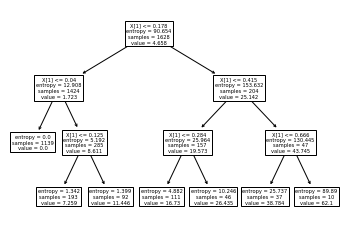

In [177]:
tree.plot_tree(reg)

In [178]:
dot_data = tree.export_graphviz(reg, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("suspension2.dot")

ExecutableNotFound: failed to execute ['dot', '-Tpdf', '-O', 'suspension2.dot'], make sure the Graphviz executables are on your systems' PATH

In [54]:
with open ("suspension.dot", "r") as fin:
    with open("suspensionR.dot","w") as fout:
        for line in fin.readlines():
            line = line.replace("X[0]","Absent")
            line = line.replace("X[1]","Bronx")
            line = line.replace("X[2]","Brooklyn")
            line = line.replace("X[3]","Manhattan")
            line = line.replace("X[4]","Queens")
            line = line.replace("X[5]","Staten Island")
            fout.write(line)

http://www.webgraphviz.com/

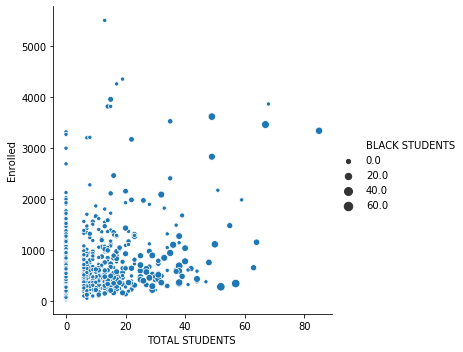

In [55]:
sns.relplot(x = "TOTAL STUDENTS ", y = "Enrolled", data = comboData, size = "BLACK STUDENTS")

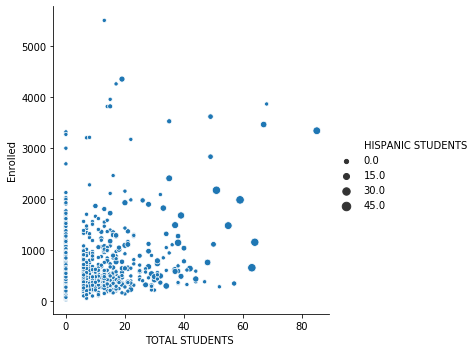

In [56]:
sns.relplot(x = "TOTAL STUDENTS ", y = "Enrolled", data = comboData, size = "HISPANIC STUDENTS")

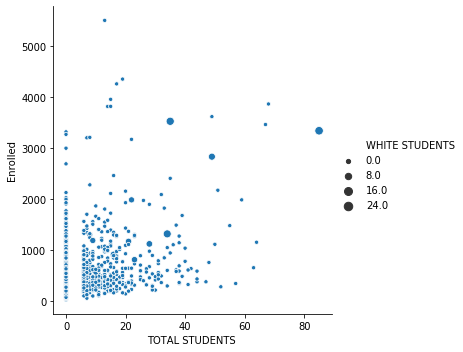

In [57]:
sns.relplot(x = "TOTAL STUDENTS ", y = "Enrolled", data = comboData, size = "WHITE STUDENTS")

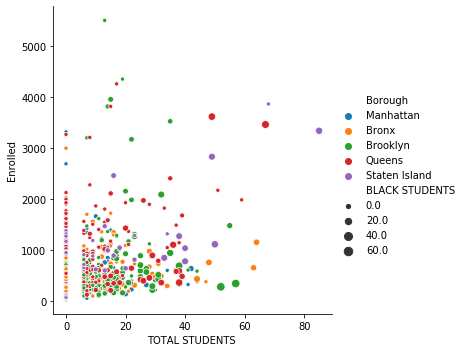

In [58]:
sns.relplot(x = "TOTAL STUDENTS ", y = "Enrolled", data = comboData, hue="Borough", size = "BLACK STUDENTS")

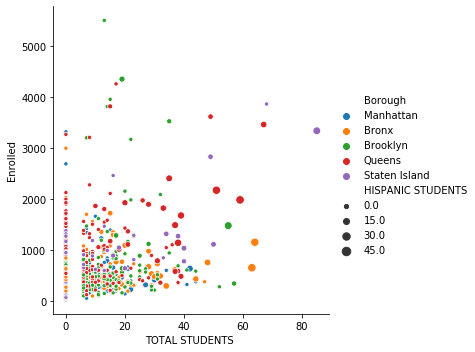

In [59]:
sns.relplot(x = "TOTAL STUDENTS ", y = "Enrolled", data = comboData, hue="Borough", size = "HISPANIC STUDENTS")

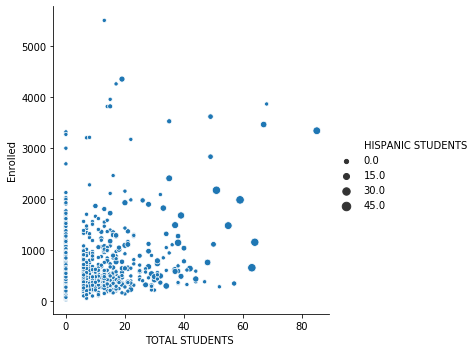

In [60]:
sns.relplot(x = "TOTAL STUDENTS ", y = "Enrolled", data = comboData, size = "HISPANIC STUDENTS")

In [61]:
X = comboData.iloc[:,[8, 9, 10]]
X.head()

,BLACK STUDENTS,HISPANIC STUDENTS,WHITE STUDENTS
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [62]:
y = comboData["Borough"]
y

0       Manhattan
1       Manhattan
2       Manhattan
3       Manhattan
4       Manhattan
          ...    
1623        Bronx
1624        Bronx
1625        Bronx
1626       Queens
1627        Bronx
Name: Borough, Length: 1628, dtype: object

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [64]:
k3nn = KNeighborsClassifier(n_neighbors = 3)
k3nn.fit(X_train, y_train)
y_pred = k3nn.predict(X_test)

In [65]:
confusion_matrix(y_test, y_pred, labels = ["Manhattan", "Brooklyn", "Bronx", "Queens", "Staten Island"])
# confusion_matrix(true value, prediction, labels = [1,0])
#this is not the statsmodels confusion matrix so different code
#this is scikit-learn

#since we imported the function 'confusion matrix', do not call the variable 
#'confusion matrix'

array([[ 0,  5,  2, 57,  1],
       [ 3, 18,  3, 74,  0],
       [ 0, 11,  3, 67,  0],
       [ 0,  6,  2, 63,  0],
       [ 0,  0,  1, 10,  0]])

In [66]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)*100
print('Accuracy of our model is equal ' + str(round(accuracy, 2)) + ' %.')

Accuracy of our model is equal 25.77 %.


In [67]:
k5nn = KNeighborsClassifier(n_neighbors = 5)
k5nn.fit(X_train, y_train)
y_pred = k5nn.predict(X_test)

In [68]:
confusion_matrix(y_test, y_pred, labels = ["Manhattan", "Brooklyn", "Bronx", "Queens", "Staten Island"])

array([[ 0,  2,  6, 57,  0],
       [ 1, 15,  4, 78,  0],
       [ 0,  5,  7, 69,  0],
       [ 0,  4,  3, 64,  0],
       [ 0,  0,  1, 10,  0]])

In [69]:
confusion_matrix(y_test, y_pred, labels = ["Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"])

array([[ 7,  5,  0, 69,  0],
       [ 4, 15,  1, 78,  0],
       [ 6,  2,  0, 57,  0],
       [ 3,  4,  0, 64,  0],
       [ 1,  0,  0, 10,  0]])

In [70]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)*100
print('Accuracy of our model is equal ' + str(round(accuracy, 2)) + ' %.')

Accuracy of our model is equal 26.38 %.


In [71]:
k7nn = KNeighborsClassifier(n_neighbors = 7)
k7nn.fit(X_train, y_train)
y_pred = k7nn.predict(X_test)

In [72]:
confusion_matrix(y_test, y_pred, labels = ["Manhattan", "Brooklyn", "Bronx", "Queens", "Staten Island"])

array([[ 0, 58,  6,  1,  0],
       [ 0, 93,  4,  1,  0],
       [ 0, 73,  7,  1,  0],
       [ 0, 68,  3,  0,  0],
       [ 0, 10,  1,  0,  0]])

In [73]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)*100
print('Accuracy of our model is equal ' + str(round(accuracy, 2)) + ' %.')

Accuracy of our model is equal 30.67 %.


In [74]:
k9nn = KNeighborsClassifier(n_neighbors = 9)
k9nn.fit(X_train, y_train)
y_pred = k9nn.predict(X_test)

In [75]:
confusion_matrix(y_test, y_pred, labels = ["Manhattan", "Brooklyn", "Bronx", "Queens", "Staten Island"])

array([[ 1, 58,  5,  1,  0],
       [ 2, 92,  4,  0,  0],
       [ 1, 73,  7,  0,  0],
       [ 0, 69,  2,  0,  0],
       [ 0, 10,  1,  0,  0]])

In [76]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)*100
print('Accuracy of our model is equal ' + str(round(accuracy, 2)) + ' %.')

Accuracy of our model is equal 30.67 %.


def knn_comparison(data, k):
    x = data[[‘X’,’y’]].values
    y = data[‘class’].astype(int).values
    clf = neighbors.KNeighborsClassifier(n_neighbors=k)
    clf.fit(x, y)# Plotting decision region
    plot_decision_regions(x, y, clf=clf, legend=2)# Adding axes annotations
    plt.xlabel(‘X’)
     plt.ylabel(‘Y’)
    plt.title(‘Knn with K=’+ str(k))
    plt.show()

In [77]:
comboData.groupby('Borough').size()

# the number of instances (rows) 
#that belong to each borough

Borough
Bronx            389
Brooklyn         497
Manhattan        311
Queens           355
Staten Island     76
dtype: int64

In [78]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
y

array([2, 2, 2, ..., 0, 3, 0])

In [79]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)



In [80]:
comboData.head()

,Unnamed: 0,DBN,Enrolled,Present,Absent,Released,ADMINISTRATIVE DISTRICT,TOTAL STUDENTS,BLACK STUDENTS,HISPANIC STUDENTS,WHITE STUDENTS,GEN ED STUDENTS,SWD STUDENTS,FEMALE STUDENTS,MALE STUDENTS,NON-ELL STUDENTS,ELL STUDENTS,NON-STH STUDENTS,STH STUDENTS,BLACK SUSPENSIONS NYPD Contact,HISPANIC SUSPENSIONS NYPD Contact,WHITE SUSPENSIONS NYPD Contact,TOTAL SUSPENSIONS NYPD Contact,GEN ED SUSPENSIONS NYPD Contact,SWD SUSPENSIONS NYPD Contact,MALE SUSPENSIONS NYPD Contact,FEMALE SUSPENSIONS NYPD Contact,NON-ELL SUSPENSIONS NYPD Contact,ELL SUSPENSIONS NYPD Contact,NON-STH SUSPENSIONS NYPD Contact,STH SUSPENSIONS NYPD Contact,Black REMOVALS,Black PRINCIPAL,Black SUPERINTENDENT,Black EXPULSIONS,Hispanic REMOVALS,Hispanic PRINCIPAL,Hispanic SUPERINTENDENT,Hispanic EXPULSIONS,White REMOVALS,White PRINCIPAL,White SUPERINTENDENT,White EXPULSIONS,Borough,BoroughNum,meanStudents
0,0,01M015,167.797753,156.005618,11.634831,0.157303,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Manhattan,2,0.000000
1,1,01M019,270.466292,246.297753,23.926966,0.241573,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Manhattan,2,0.000000
2,2,01M020,574.067416,539.679775,33.898876,0.488764,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Manhattan,2,0.000000
3,3,01M034,393.977528,360.679775,33.112360,0.185393,1,14.0,0.0,0.0,0.0,8.0,6.0,8.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,10.0,9.0,0.0,14.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,Manhattan,2,0.184623
4,4,01M063,200.382022,187.061798,13.073034,0.247191,1,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Manhattan,2,0.079124


In [81]:
z = comboData.iloc[:,[8, 9, 10, 43 ]]
z.head()


,BLACK STUDENTS,HISPANIC STUDENTS,WHITE STUDENTS,Borough
0,0.0,0.0,0.0,Manhattan
1,0.0,0.0,0.0,Manhattan
2,0.0,0.0,0.0,Manhattan
3,0.0,0.0,0.0,Manhattan
4,0.0,0.0,0.0,Manhattan


/Users/zeigna/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/zeigna/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/zeigna/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


<Figure size 432x288 with 0 Axes>

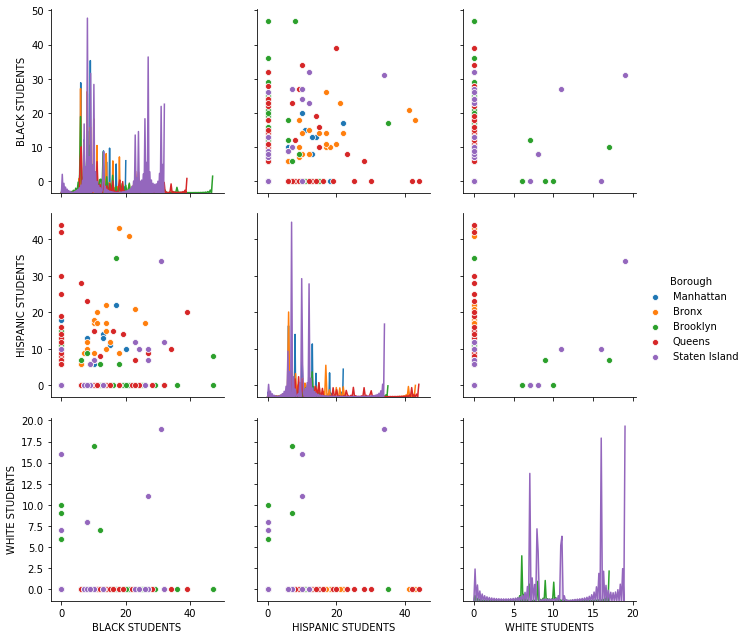

In [82]:

plt.figure()
sns.pairplot(z, hue = "Borough", size=3)
plt.show()



<Figure size 432x288 with 0 Axes>

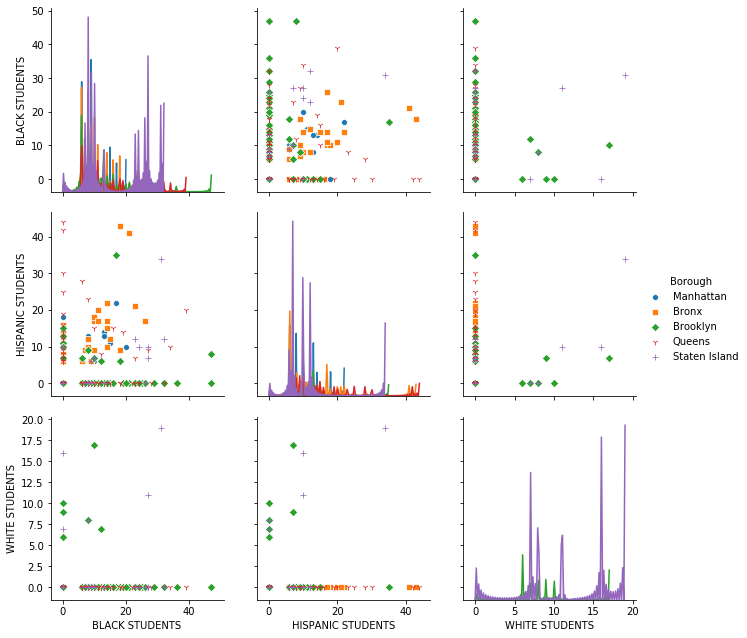

In [83]:

plt.figure()
sns.pairplot(z, hue = "Borough", size=3, markers=["o", "s", "D", "1", "+"])
plt.show()


<Figure size 432x288 with 0 Axes>

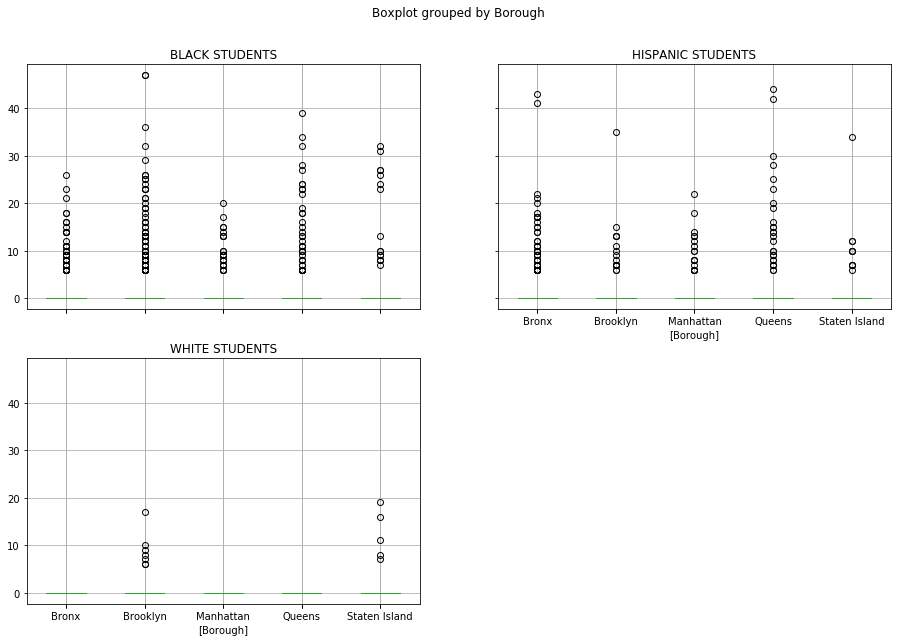

In [84]:
plt.figure()
z.boxplot(by="Borough", figsize=(15, 10))
plt.show()

In [85]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)*100
print('Accuracy of our model is equal ' + str(round(accuracy, 2)) + ' %.')

Accuracy of our model is equal 0.0 %.


In [88]:
comboData.dtypes

Unnamed: 0                             int64
DBN                                   object
Enrolled                             float64
Present                              float64
Absent                               float64
Released                             float64
ADMINISTRATIVE DISTRICT                int64
TOTAL STUDENTS                       float64
BLACK STUDENTS                       float64
HISPANIC STUDENTS                    float64
WHITE STUDENTS                       float64
GEN ED STUDENTS                      float64
SWD STUDENTS                         float64
FEMALE STUDENTS                      float64
MALE STUDENTS                        float64
NON-ELL STUDENTS                     float64
ELL STUDENTS                         float64
NON-STH STUDENTS                     float64
STH STUDENTS                         float64
BLACK SUSPENSIONS NYPD Contact       float64
HISPANIC SUSPENSIONS NYPD Contact    float64
WHITE SUSPENSIONS NYPD Contact       float64
TOTAL SUSP

In [90]:
comboRed = comboData.iloc[:,[2, 3, 4, 8, 9, 10, 43, 44 ]]
comboRed.head()

,Enrolled,Present,Absent,BLACK STUDENTS,HISPANIC STUDENTS,WHITE STUDENTS,Borough,BoroughNum
0,167.797753,156.005618,11.634831,0.0,0.0,0.0,Manhattan,2
1,270.466292,246.297753,23.926966,0.0,0.0,0.0,Manhattan,2
2,574.067416,539.679775,33.898876,0.0,0.0,0.0,Manhattan,2
3,393.977528,360.679775,33.112360,0.0,0.0,0.0,Manhattan,2
4,200.382022,187.061798,13.073034,0.0,0.0,0.0,Manhattan,2


In [86]:
scaler = StandardScaler()

In [91]:
scaler.fit(comboRed.drop(['Borough', 'BoroughNum'], axis = 1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [92]:
scaled_features = scaler.transform(comboRed.drop(['Borough', 'BoroughNum'], axis = 1))

In [93]:
scaled_features

array([[-0.87792398, -0.85047638, -0.82443804, -0.3274426 , -0.23180663,
        -0.07944162],
       [-0.66956187, -0.65442349, -0.55969427, -0.3274426 , -0.23180663,
        -0.07944162],
       [-0.05341431, -0.01739801, -0.3449227 , -0.3274426 , -0.23180663,
        -0.07944162],
       ...,
       [ 0.06699224, -0.03682681,  0.98753641, -0.3274426 , -0.23180663,
        -0.07944162],
       [-0.11277457, -0.67741237,  4.89947179, -0.3274426 , -0.23180663,
        -0.07944162],
       [-0.66313143, -0.72227106, -0.13087712, -0.3274426 , -0.23180663,
        -0.07944162]])

In [96]:
df_feat = pd.DataFrame(scaled_features, columns = comboRed.columns[:-2])

In [97]:
df_feat.head()

,Enrolled,Present,Absent,BLACK STUDENTS,HISPANIC STUDENTS,WHITE STUDENTS
0,-0.877924,-0.850476,-0.824438,-0.327443,-0.231807,-0.079442
1,-0.669562,-0.654423,-0.559694,-0.327443,-0.231807,-0.079442
2,-0.053414,-0.017398,-0.344923,-0.327443,-0.231807,-0.079442
3,-0.418900,-0.406064,-0.361862,-0.327443,-0.231807,-0.079442
4,-0.811795,-0.783044,-0.793463,-0.327443,-0.231807,-0.079442


In [ ]:
from sklearn.cross_validation import train_test_split

In [136]:
X = df_feat
y = comboRed['BoroughNum']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [120]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [121]:
pred = knn.predict(X_test)
pred

array([2, 5, 2, 1, 1, 3, 1, 1, 4, 1, 4, 2, 1, 1, 3, 4, 5, 4, 4, 5, 1, 5,
       5, 5, 1, 1, 5, 4, 5, 5, 4, 4, 2, 3, 1, 2, 1, 1, 5, 1, 5, 3, 4, 1,
       2, 5, 5, 5, 2, 1, 1, 4, 1, 5, 5, 5, 4, 5, 5, 1, 1, 1, 4, 4, 3, 2,
       4, 1, 1, 4, 1, 1, 4, 3, 4, 2, 1, 2, 4, 2, 2, 1, 5, 1, 2, 1, 2, 4,
       5, 4, 2, 5, 2, 1, 4, 5, 2, 5, 2, 1, 1, 1, 4, 1, 5, 4, 4, 5, 1, 5,
       1, 1, 4, 4, 5, 4, 1, 5, 5, 1, 5, 2, 1, 4, 2, 4, 1, 1, 1, 1, 5, 4,
       5, 2, 1, 1, 4, 5, 4, 1, 1, 4, 4, 5, 1, 2, 3, 4, 2, 1, 1, 1, 2, 2,
       3, 4, 1, 1, 1, 1, 4, 1, 2, 1, 3, 4, 1, 5, 1, 4, 4, 2, 5, 4, 3, 1,
       4, 5, 1, 5, 5, 1, 5, 1, 5, 1, 5, 2, 2, 1, 1, 2, 1, 5, 2, 1, 5, 1,
       4, 1, 5, 5, 2, 4, 1, 2, 1, 4, 1, 5, 4, 4, 2, 3, 5, 4, 4, 1, 2, 3,
       4, 4, 2, 2, 4, 2, 1, 2, 4, 1, 5, 1, 1, 5, 1, 5, 2, 5, 4, 1, 1, 4,
       1, 5, 4, 1, 1, 1, 4, 1, 5, 2, 4, 3, 2, 1, 1, 1, 1, 2, 3, 3, 1, 5,
       5, 1, 2, 3, 2, 1, 4, 4, 2, 4, 1, 2, 4, 1, 1, 1, 5, 4, 5, 1, 2, 1,
       1, 1, 1, 5, 5, 1, 4, 1, 5, 5, 4, 1, 1, 4, 4,

In [122]:
from sklearn.metrics import classification_report, confusion_matrix

In [123]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[47 10  2 10 12]
 [20 15  1 21 11]
 [ 4  2  3  5  0]
 [26 12  6 22 24]
 [19 11  4 17 22]]
              precision    recall  f1-score   support

           1       0.41      0.58      0.48        81
           2       0.30      0.22      0.25        68
           3       0.19      0.21      0.20        14
           4       0.29      0.24      0.27        90
           5       0.32      0.30      0.31        73

    accuracy                           0.33       326
   macro avg       0.30      0.31      0.30       326
weighted avg       0.32      0.33      0.32       326



In [124]:
k5nn = KNeighborsClassifier(n_neighbors = 5)
k5nn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [125]:
pred5 = k5nn.predict(X_test)
pred5

array([2, 5, 4, 1, 1, 5, 1, 1, 4, 2, 2, 2, 1, 4, 3, 4, 5, 4, 1, 5, 1, 5,
       5, 5, 1, 1, 4, 4, 4, 2, 4, 1, 2, 3, 5, 2, 1, 4, 5, 1, 1, 3, 4, 1,
       4, 4, 5, 5, 2, 5, 2, 4, 1, 5, 5, 5, 4, 5, 5, 1, 1, 1, 4, 4, 5, 5,
       4, 1, 1, 1, 1, 5, 4, 3, 4, 4, 2, 1, 1, 2, 2, 4, 5, 1, 2, 1, 2, 4,
       5, 4, 2, 1, 4, 1, 4, 5, 2, 5, 1, 4, 1, 1, 4, 1, 5, 4, 4, 5, 1, 4,
       1, 1, 4, 4, 5, 4, 1, 1, 1, 1, 3, 2, 2, 4, 5, 4, 2, 2, 1, 2, 5, 4,
       5, 2, 1, 5, 4, 5, 4, 1, 1, 2, 4, 2, 4, 2, 5, 4, 2, 1, 1, 1, 2, 4,
       5, 4, 1, 1, 1, 3, 5, 1, 4, 1, 3, 4, 4, 4, 1, 3, 4, 5, 1, 4, 5, 1,
       4, 5, 1, 5, 1, 1, 5, 4, 1, 4, 5, 2, 2, 1, 1, 5, 1, 5, 2, 1, 1, 1,
       4, 1, 5, 1, 2, 4, 1, 5, 1, 4, 4, 1, 4, 4, 2, 3, 5, 4, 4, 1, 2, 5,
       4, 4, 2, 1, 4, 2, 1, 2, 4, 1, 2, 1, 1, 5, 1, 5, 2, 1, 2, 2, 1, 4,
       1, 5, 4, 1, 1, 1, 4, 1, 5, 2, 2, 2, 2, 1, 1, 1, 1, 2, 5, 4, 1, 4,
       5, 4, 4, 4, 2, 1, 4, 4, 2, 1, 1, 2, 4, 2, 1, 1, 4, 4, 5, 1, 5, 1,
       1, 3, 1, 5, 5, 1, 2, 1, 5, 4, 4, 2, 4, 4, 4,

In [126]:
print(confusion_matrix(y_test, pred5))
print(classification_report(y_test, pred5))

[[44 13  2 14  8]
 [17 13  1 27 10]
 [ 2  3  3  6  0]
 [23 12  3 27 25]
 [19 12  1 20 21]]
              precision    recall  f1-score   support

           1       0.42      0.54      0.47        81
           2       0.25      0.19      0.21        68
           3       0.30      0.21      0.25        14
           4       0.29      0.30      0.29        90
           5       0.33      0.29      0.31        73

    accuracy                           0.33       326
   macro avg       0.32      0.31      0.31       326
weighted avg       0.32      0.33      0.32       326



In [127]:
k7nn = KNeighborsClassifier(n_neighbors = 7)
k7nn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [128]:
pred7 = k7nn.predict(X_test)
pred7

array([1, 5, 4, 1, 1, 5, 1, 1, 4, 2, 2, 2, 1, 1, 3, 4, 2, 4, 4, 5, 1, 5,
       5, 3, 1, 1, 4, 4, 4, 2, 4, 4, 2, 3, 5, 4, 1, 4, 5, 2, 1, 5, 4, 1,
       4, 4, 5, 5, 4, 5, 4, 4, 1, 5, 5, 1, 4, 5, 5, 1, 1, 1, 4, 4, 3, 5,
       4, 1, 4, 1, 1, 5, 4, 4, 4, 4, 1, 2, 4, 5, 2, 4, 5, 1, 2, 1, 2, 4,
       5, 2, 5, 1, 4, 1, 4, 1, 2, 5, 1, 4, 1, 1, 4, 1, 5, 4, 4, 5, 4, 4,
       2, 1, 4, 4, 5, 4, 1, 1, 1, 1, 3, 2, 4, 4, 5, 4, 1, 2, 4, 1, 5, 4,
       4, 2, 1, 5, 4, 5, 1, 1, 1, 2, 4, 2, 4, 5, 4, 4, 2, 2, 1, 1, 2, 4,
       3, 4, 1, 1, 4, 1, 5, 1, 4, 1, 5, 4, 4, 4, 1, 4, 4, 5, 4, 4, 5, 1,
       4, 5, 2, 4, 1, 1, 5, 4, 5, 4, 5, 2, 2, 1, 1, 1, 1, 5, 2, 1, 1, 1,
       4, 1, 5, 1, 2, 4, 1, 5, 1, 4, 4, 5, 4, 4, 2, 5, 5, 4, 4, 1, 2, 5,
       4, 2, 2, 1, 4, 1, 1, 5, 4, 1, 2, 1, 1, 4, 1, 5, 2, 5, 2, 2, 1, 4,
       1, 5, 4, 1, 1, 1, 4, 1, 5, 2, 2, 2, 2, 1, 4, 1, 1, 2, 5, 4, 1, 4,
       5, 4, 2, 4, 5, 1, 4, 4, 2, 4, 1, 2, 4, 2, 1, 1, 4, 1, 2, 1, 5, 1,
       1, 3, 1, 5, 5, 1, 2, 1, 5, 4, 4, 4, 4, 4, 4,

In [129]:
print(confusion_matrix(y_test, pred7))
print("\n")
print(classification_report(y_test, pred7))
print("\n")
accuracy = accuracy_score(y_test, pred7)*100
print('Accuracy of our model is equal ' + str(round(accuracy, 2)) + ' %.')

[[41 14  1 19  6]
 [16 13  0 26 13]
 [ 2  3  2  7  0]
 [24 13  4 30 19]
 [17  5  0 26 25]]
              precision    recall  f1-score   support

           1       0.41      0.51      0.45        81
           2       0.27      0.19      0.22        68
           3       0.29      0.14      0.19        14
           4       0.28      0.33      0.30        90
           5       0.40      0.34      0.37        73

    accuracy                           0.34       326
   macro avg       0.33      0.30      0.31       326
weighted avg       0.34      0.34      0.33       326



In [112]:
#Elbow method

error_rate = []

for i in range (1, 15):
    
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

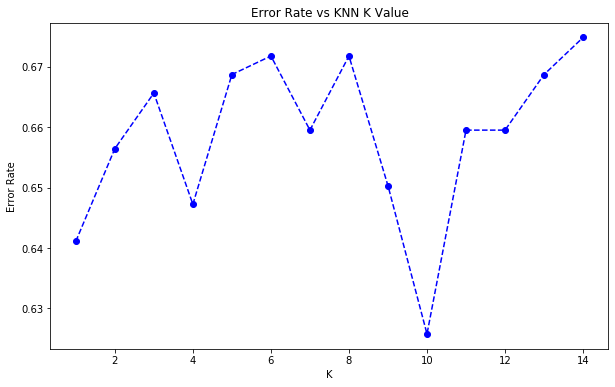

In [119]:
plt.figure(figsize = (10,6))
plt.plot(range(1, 15), error_rate, color='blue', linestyle = 'dashed', marker = 'o')
plt.title("Error Rate vs KNN K Value")
plt.xlabel("K")
plt.ylabel("Error Rate")

In [116]:
error_rate

[0.6411042944785276,
 0.656441717791411,
 0.6656441717791411,
 0.647239263803681,
 0.6687116564417178,
 0.6717791411042945,
 0.6595092024539877,
 0.6717791411042945,
 0.6503067484662577,
 0.6257668711656442,
 0.6595092024539877,
 0.6595092024539877,
 0.6687116564417178,
 0.6748466257668712]

In [130]:
k10nn = KNeighborsClassifier(n_neighbors = 10)
k10nn.fit(X_train, y_train)
pred10 = k10nn.predict(X_test)
pred10

array([2, 5, 4, 4, 1, 4, 1, 1, 4, 2, 2, 2, 1, 2, 4, 4, 5, 4, 4, 5, 4, 4,
       5, 5, 1, 1, 4, 4, 4, 2, 4, 4, 4, 3, 5, 4, 1, 4, 5, 2, 1, 5, 4, 1,
       5, 4, 5, 5, 5, 5, 4, 4, 1, 5, 5, 5, 4, 5, 5, 1, 1, 1, 4, 5, 5, 5,
       4, 1, 1, 1, 1, 5, 4, 4, 1, 2, 1, 2, 1, 2, 4, 1, 5, 1, 2, 1, 1, 4,
       5, 4, 5, 5, 4, 1, 4, 1, 2, 5, 1, 4, 1, 1, 4, 1, 1, 1, 4, 5, 4, 5,
       4, 1, 4, 1, 5, 5, 1, 1, 1, 1, 5, 2, 4, 4, 5, 4, 1, 2, 4, 2, 5, 4,
       5, 2, 1, 1, 1, 5, 1, 1, 1, 4, 4, 2, 4, 5, 5, 4, 2, 1, 1, 1, 4, 4,
       5, 4, 1, 1, 1, 1, 5, 1, 4, 1, 5, 4, 4, 4, 1, 4, 4, 4, 1, 4, 5, 1,
       4, 4, 1, 4, 1, 1, 5, 4, 5, 4, 5, 1, 2, 1, 1, 4, 1, 5, 2, 1, 1, 1,
       4, 1, 5, 1, 2, 4, 1, 5, 1, 4, 4, 1, 4, 4, 2, 5, 5, 4, 4, 1, 2, 1,
       4, 4, 2, 1, 4, 1, 1, 4, 4, 1, 1, 1, 2, 4, 1, 5, 2, 1, 4, 4, 1, 4,
       1, 5, 4, 2, 1, 1, 4, 1, 5, 5, 4, 3, 2, 4, 4, 1, 1, 1, 4, 4, 2, 4,
       5, 5, 2, 4, 2, 1, 4, 4, 2, 4, 1, 2, 4, 4, 5, 1, 4, 2, 2, 1, 5, 1,
       1, 4, 1, 5, 5, 1, 1, 1, 5, 4, 4, 4, 1, 4, 4,

In [132]:
print(confusion_matrix(y_test, pred))
print('\n')
print(classification_report(y_test, pred))

[[47 10  2 10 12]
 [20 15  1 21 11]
 [ 4  2  3  5  0]
 [26 12  6 22 24]
 [19 11  4 17 22]]


              precision    recall  f1-score   support

           1       0.41      0.58      0.48        81
           2       0.30      0.22      0.25        68
           3       0.19      0.21      0.20        14
           4       0.29      0.24      0.27        90
           5       0.32      0.30      0.31        73

    accuracy                           0.33       326
   macro avg       0.30      0.31      0.30       326
weighted avg       0.32      0.33      0.32       326



In [149]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

In [151]:
dtree = DecisionTreeClassifier()

In [142]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [145]:
prediction = dtree.predict(X_test)

In [148]:
print(confusion_matrix(y_test, prediction))
print('\n')
print(classification_report(y_test, prediction))

[[21 21  1 23 15]
 [19 15  1 16 17]
 [ 3  2  0  5  4]
 [19  3 12 28 28]
 [ 6 10  4 20 33]]


              precision    recall  f1-score   support

           1       0.31      0.26      0.28        81
           2       0.29      0.22      0.25        68
           3       0.00      0.00      0.00        14
           4       0.30      0.31      0.31        90
           5       0.34      0.45      0.39        73

    accuracy                           0.30       326
   macro avg       0.25      0.25      0.25       326
weighted avg       0.30      0.30      0.29       326



In [147]:
print(classification_report)

<function classification_report at 0x1a1f633170>


In [152]:
dtreeR = DecisionTreeRegressor()

In [153]:
dtreeR.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [154]:
prediction = dtreeR.predict(X_test)

In [155]:
print(confusion_matrix(y_test, prediction))
print('\n')
print(classification_report(y_test, prediction))

[[34 17  1 13 16]
 [10 17  2 22 17]
 [ 1  1  1  8  3]
 [21 11  8 25 25]
 [13  7  4 23 26]]


              precision    recall  f1-score   support

           1       0.43      0.42      0.43        81
           2       0.32      0.25      0.28        68
           3       0.06      0.07      0.07        14
           4       0.27      0.28      0.28        90
           5       0.30      0.36      0.33        73

    accuracy                           0.32       326
   macro avg       0.28      0.28      0.27       326
weighted avg       0.32      0.32      0.32       326



In [158]:
X2 = comboData.iloc[:,[8, 9, 10]]
X2.head()

,BLACK STUDENTS,HISPANIC STUDENTS,WHITE STUDENTS
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [159]:
y2 = comboData["Borough"]
y2

0       Manhattan
1       Manhattan
2       Manhattan
3       Manhattan
4       Manhattan
          ...    
1623        Bronx
1624        Bronx
1625        Bronx
1626       Queens
1627        Bronx
Name: Borough, Length: 1628, dtype: object

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2)

In [161]:
knn2 = KNeighborsClassifier(n_neighbors = 3)
knn2.fit(X_train, y_train)
pred2 = knn2.predict(X_test)
pred2

array(['Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx',
       'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx',
       'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx',
       'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Queens',
       'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx',
       'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx',
       'Bronx', 'Bronx', 'Brooklyn', 'Bronx', 'Bronx', 'Bronx', 'Bronx',
       'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Brooklyn', 'Bronx', 'Bronx',
       'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx',
       'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx',
       'Brooklyn', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx',
       'Bronx', 'Queens', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx',
       'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx',
       'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx', 'Bronx',
       'B

In [162]:
print(confusion_matrix(y_test, pred2))
print('\n')
print(classification_report(y_test, pred2))

[[78  1  0  0  0]
 [95  9  2  1  1]
 [61  0  2  0  0]
 [53  4  1  1  1]
 [15  1  0  0  0]]


               precision    recall  f1-score   support

        Bronx       0.26      0.99      0.41        79
     Brooklyn       0.60      0.08      0.15       108
    Manhattan       0.40      0.03      0.06        63
       Queens       0.50      0.02      0.03        60
Staten Island       0.00      0.00      0.00        16

     accuracy                           0.28       326
    macro avg       0.35      0.22      0.13       326
 weighted avg       0.43      0.28      0.17       326



In [169]:
dtreeR2 = DecisionTreeClassifier()
dtreeR2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [170]:
prediction = dtreeR2.predict(X_test)

In [171]:
print(confusion_matrix(y_test, prediction))
print('\n')
print(classification_report(y_test, prediction))

[[  8  71   0   0   0]
 [  2 104   0   1   1]
 [  2  61   0   0   0]
 [  2  54   1   2   1]
 [  1  13   0   0   2]]


               precision    recall  f1-score   support

        Bronx       0.53      0.10      0.17        79
     Brooklyn       0.34      0.96      0.51       108
    Manhattan       0.00      0.00      0.00        63
       Queens       0.67      0.03      0.06        60
Staten Island       0.50      0.12      0.20        16

     accuracy                           0.36       326
    macro avg       0.41      0.24      0.19       326
 weighted avg       0.39      0.36      0.23       326

